# Lenia [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/20_lenia.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [ ]:
import pickle
from importlib import resources

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy
from flax import nnx

from cax.systems.lenia import (
	FreeKernelParams,
	GrowthParams,
	KernelParams,
	Lenia,
	RuleParams,
	exponential_growth_fn,
	free_kernel_fn,
	gaussian_kernel_fn,
	polynomial_kernel_fn,
)

## Configuration

In [2]:
seed = 0

spatial_dims = (128, 128)
channel_size = 3

R = 12
T = 2

state_scale = 2

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Model

This section demonstrates how to visualize well-known Lenia creatures by loading rule parameters and patterns from `cax/models/lenia/assets`.

You can run either the VT049W or 5N7KKM section below. You can also experiment with combining rule parameters from one soliton with the pattern of another to observe novel emergent behaviors.

### VT049W

In [3]:
# Load rule params for soliton VT049W
with (
	resources.files("cax.systems.lenia.assets.VT049W").joinpath("rule_params.pickle").open("rb") as f
):
	rule_params = pickle.load(f)

In [4]:
# Load pattern for soliton VT049W
with resources.files("cax.systems.lenia.assets.VT049W").joinpath("Aquarium.pickle").open("rb") as f:
	pattern = pickle.load(f)

### 5N7KKM

In [5]:
# Load rule params for soliton 5N7KKM
with (
	resources.files("cax.systems.lenia.assets.5N7KKM").joinpath("rule_params.pickle").open("rb") as f
):
	rule_params = pickle.load(f)

In [6]:
# Load pattern for soliton 5N7KKM
with (
	resources.files("cax.systems.lenia.assets.5N7KKM")
	.joinpath("Aquarium_swarm.pickle")
	.open("rb") as f
):
	pattern = pickle.load(f)

In [7]:
ca = Lenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	rule_params=rule_params,
	state_scale=state_scale,
)

## Sample initial state

In [8]:
def sample_state(pattern):
	"""Sample a state with a pattern at the center."""
	# Calculate the center of the state for each dimension
	mid = tuple(dim // 2 for dim in spatial_dims)

	# Scale pattern
	pattern_scaled = pattern
	for axis in range(len(spatial_dims)):
		pattern_scaled = pattern_scaled.repeat(state_scale, axis=axis)

	# Get the shape of the scaled cells
	pattern_spatial_dims = pattern_scaled.shape[:-1]  # Exclude the channel dimension

	# Create empty state with the shape defined by spatial_dims and channel_size
	state = jnp.zeros((*spatial_dims, channel_size))

	# Calculate the slice indices for each dimension
	slices = tuple(slice(m - c // 2, m + c - c // 2) for m, c in zip(mid, pattern_spatial_dims))

	# Place the scaled cells in the center of the state
	state = state.at[slices].set(pattern_scaled)

	return state

## Run

In [9]:
state_init = sample_state(pattern)
state_final, states = ca(state_init, num_steps=256)

## Visualize


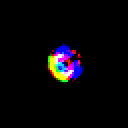

In [10]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")

## Rule Parameters

In this section, we will deep dive into what are the rule parameters in Lenia and explore the `RuleParams` object provided by CAX, how it works, and how you can define your own rule parameters to experiment with new Lenia worlds.

The Lenia implementation in CAX rigorously follows:
- [1] [Lenia - Biology of Artificial Life, Chan (2018)](https://arxiv.org/abs/1812.05433)
- [2] [Lenia and Expanded Universe, Chan (2020)](https://arxiv.org/abs/2005.03742)

In Lenia, the state is a $d$-dimensional lattice $A^{t}$ with $c$ channels that evolves from $A^t$ to $A^{t+dt}$ based on a set of rules. Each rule consists of a source channel, a target channel, a weight, a kernel and a growth mapping function, see [1, 2] for more details.

In CAX, the parameters of a rule are defined through the `RuleParams` object. For example:

In [12]:
rule_params = RuleParams(
	channel_source=0,
	channel_target=1,
	weight=1.0,
	kernel_params=KernelParams(
		r=0.82,
		b=jnp.array([1 / 6, 1.0, 0.2]),
	),
	growth_params=GrowthParams(
		mean=0.0,
		std=0.05,
	),
)

We will now explore how to define custom kernels and growth mapping functions.

### Kernels

This section explores the kernel functions available in Lenia through CAX. We"ll examine the built-in kernel functions and demonstrate how to create custom kernels for your own experiments.

The original kernel functions are defined in [1, 2] and the free kernel function is defined in Flow-Lenia.

#### Original kernel function

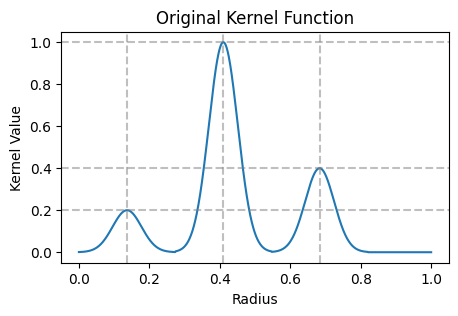

In [13]:
kernel_params = KernelParams(
	r=0.82,
	b=jnp.array([0.2, 1.0, 0.4]),
)

# Plot the original kernel function
radius = jnp.linspace(0.0, 1.0, 1000)
kernel_values = gaussian_kernel_fn(radius, kernel_params)

plt.figure(figsize=(5, 3))
plt.plot(radius, kernel_values)

# Add horizontal lines for b values
for b in kernel_params.b:
	plt.axhline(y=b, color="gray", linestyle="--", alpha=0.5)

# Add vertical lines at peaks (segment boundaries)
number_of_segments = jnp.count_nonzero(~jnp.isnan(kernel_params.b), axis=-1)
for i in range(number_of_segments):
	peak_x = (i + 0.5) * kernel_params.r / number_of_segments
	plt.axvline(x=peak_x, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Radius")
plt.ylabel("Kernel Value")
plt.title("Original Kernel Function")
plt.show()

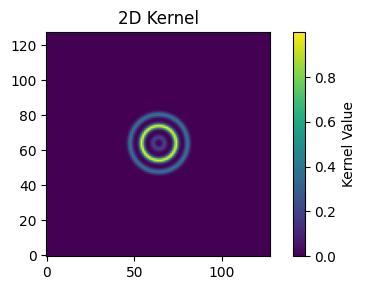

In [14]:
# Create a 2D grid for the kernel
x = jnp.mgrid[[slice(-dim // 2, dim // 2) for dim in spatial_dims]] / (state_scale * R)
d = jnp.linalg.norm(x, axis=0)

# Apply the kernel function to the distances
kernel_2d = gaussian_kernel_fn(jnp.array(d), kernel_params)

# Plot the 2D kernel
plt.figure(figsize=(5, 3))
plt.imshow(kernel_2d, origin="lower")

plt.title("2D Kernel")
plt.colorbar(label="Kernel Value")

plt.tight_layout()
plt.show()

#### Free kernel function

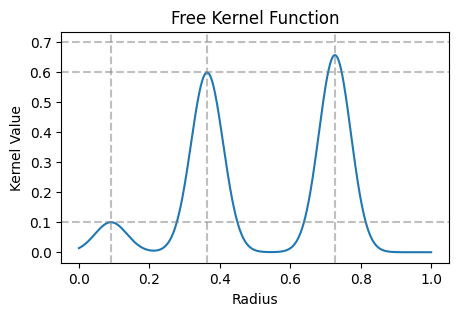

In [15]:
kernel_params = FreeKernelParams(
	r=0.91,
	b=jnp.array([0.1, 0.6, 0.7]),
	a=jnp.array([0.1, 0.4, 0.8]),
	w=jnp.array([0.05, 0.05, 0.05]),
)

# Plot the free kernel function
radius = jnp.linspace(0.0, 1.0, 1000)
kernel_values = jax.vmap(free_kernel_fn, in_axes=(0, None))(radius, kernel_params)

plt.figure(figsize=(5, 3))
plt.plot(radius, kernel_values)

# Add horizontal lines for b values
for b in kernel_params.b:
	plt.axhline(y=b, color="gray", linestyle="--", alpha=0.5)

# Add vertical lines at peak positions
for a in kernel_params.a:
	plt.axvline(x=a * kernel_params.r, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Radius")
plt.ylabel("Kernel Value")
plt.title("Free Kernel Function")
plt.show()

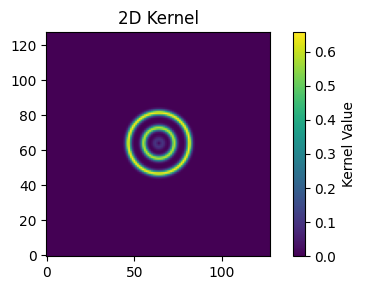

In [16]:
# Create a 2D grid for the kernel
x = jnp.mgrid[[slice(-dim // 2, dim // 2) for dim in spatial_dims]] / (state_scale * R)
d = jnp.linalg.norm(x, axis=0)

# Apply the kernel function to the distances
kernel_2d = free_kernel_fn(jnp.array(d), kernel_params)

# Plot the 2D kernel
plt.figure(figsize=(5, 3))
plt.imshow(kernel_2d, origin="lower")

plt.title("2D Kernel")
plt.colorbar(label="Kernel Value")

plt.tight_layout()
plt.show()

### Growth Mapping Function

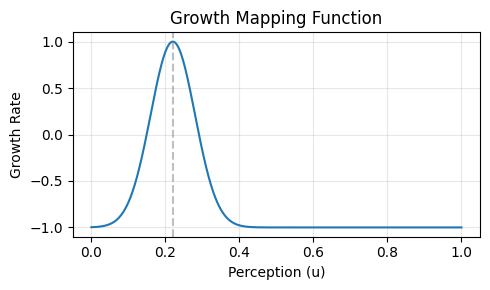

In [17]:
growth_params = GrowthParams(
	mean=0.22,
	std=0.06,
)

# Plot the growth mapping function
u_values = jnp.linspace(0, 1, 1000)
growth_values = exponential_growth_fn(u_values, growth_params)

plt.figure(figsize=(5, 3))
plt.plot(u_values, growth_values)

# Add vertical line at the mean
plt.axvline(x=growth_params.mean, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Perception (u)")
plt.ylabel("Growth Rate")

plt.title("Growth Mapping Function")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Orbium - Putting it Together

In [21]:
spatial_dims = (128, 128)
channel_size = 1

R = 12
T = 10

state_scale = 2

#### Kernel

In [22]:
kernel_params = KernelParams(
	r=jnp.array(1.0, jnp.float32),
	b=jnp.array([1.0]),
)

#### Growth Mapping Function

In [23]:
growth_params = GrowthParams(
	mean=jnp.array(0.15, jnp.float32),
	std=jnp.array(0.015, jnp.float32),
)

#### Rule Params

In [25]:
rule_params = RuleParams(
	channel_source=jnp.array(0, jnp.int32),
	channel_target=jnp.array(0, jnp.int32),
	weight=jnp.array(1.0, jnp.float32),
	kernel_params=kernel_params,
	growth_params=growth_params,
)
rule_params = jax.tree.map(lambda x: x[None], rule_params)

#### Model

In [26]:
ca = Lenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	state_scale=state_scale,
	rule_params=rule_params,
)

#### Sample initial state

In [27]:
def sample_state(pattern):
	"""Sample a state with a pattern at the center."""
	# Calculate the center of the state for each dimension
	mid = tuple(dim // 2 for dim in spatial_dims)

	# Scale pattern
	pattern_scaled = pattern
	for axis in range(len(spatial_dims)):
		pattern_scaled = pattern_scaled.repeat(state_scale, axis=axis)

	# Get the shape of the scaled cells
	pattern_spatial_dims = pattern_scaled.shape[:-1]  # Exclude the channel dimension

	# Create empty state with the shape defined by spatial_dims and channel_size
	state = jnp.zeros((*spatial_dims, channel_size))

	# Calculate the slice indices for each dimension
	slices = tuple(slice(m - c // 2, m + c - c // 2) for m, c in zip(mid, pattern_spatial_dims))

	# Place the scaled cells in the center of the state
	state = state.at[slices].set(pattern_scaled)

	return state

#### Run

In [28]:
# ruff: noqa: E501
# fmt: off
orbium = jnp.array(
	[
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.14, 0.1, 0.0, 0.0, 0.03, 0.03, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.24, 0.3, 0.3, 0.18, 0.14, 0.15, 0.16, 0.15, 0.09, 0.2, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.34, 0.44, 0.46, 0.38, 0.18, 0.14, 0.11, 0.13, 0.19, 0.18, 0.45, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.06, 0.13, 0.39, 0.5, 0.5, 0.37, 0.06, 0.0, 0.0, 0.0, 0.02, 0.16, 0.68, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.11, 0.17, 0.17, 0.33, 0.4, 0.38, 0.28, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.42, 0.0, 0.0],
		[0.0, 0.0, 0.09, 0.18, 0.13, 0.06, 0.08, 0.26, 0.32, 0.32, 0.27, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.0, 0.0],
		[0.27, 0.0, 0.16, 0.12, 0.0, 0.0, 0.0, 0.25, 0.38, 0.44, 0.45, 0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.17, 0.0],
		[0.0, 0.07, 0.2, 0.02, 0.0, 0.0, 0.0, 0.31, 0.48, 0.57, 0.6, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49, 0.0],
		[0.0, 0.59, 0.19, 0.0, 0.0, 0.0, 0.0, 0.2, 0.57, 0.69, 0.76, 0.76, 0.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0],
		[0.0, 0.58, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.67, 0.83, 0.9, 0.92, 0.87, 0.12, 0.0, 0.0, 0.0, 0.0, 0.22, 0.07],
		[0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.93, 1.0, 1.0, 1.0, 0.61, 0.0, 0.0, 0.0, 0.0, 0.18, 0.11],
		[0.0, 0.0, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47, 1.0, 1.0, 0.98, 1.0, 0.96, 0.27, 0.0, 0.0, 0.0, 0.19, 0.1],
		[0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 1.0, 0.84, 0.92, 0.97, 0.54, 0.14, 0.04, 0.1, 0.21, 0.05],
		[0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.09, 0.8, 1.0, 0.82, 0.8, 0.85, 0.63, 0.31, 0.18, 0.19, 0.2, 0.01],
		[0.0, 0.0, 0.0, 0.36, 0.1, 0.0, 0.0, 0.0, 0.05, 0.54, 0.86, 0.79, 0.74, 0.72, 0.6, 0.39, 0.28, 0.24, 0.13, 0.0],
		[0.0, 0.0, 0.0, 0.01, 0.3, 0.07, 0.0, 0.0, 0.08, 0.36, 0.64, 0.7, 0.64, 0.6, 0.51, 0.39, 0.29, 0.19, 0.04, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.1, 0.24, 0.14, 0.1, 0.15, 0.29, 0.45, 0.53, 0.52, 0.46, 0.4, 0.31, 0.21, 0.08, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.21, 0.21, 0.22, 0.29, 0.36, 0.39, 0.37, 0.33, 0.26, 0.18, 0.09, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.13, 0.19, 0.22, 0.24, 0.24, 0.23, 0.18, 0.13, 0.05, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.06, 0.08, 0.09, 0.07, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
	]
)[..., None]

In [29]:
state_init = sample_state(orbium)
states_final, states = ca(state_init, num_steps=256)

#### Visualize


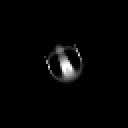

In [34]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")

### Rotator - Using a different type of kernel function

In this section, we demonstrate how to visualize a different pattern, called rotator.

We also show the effect of using a larger state size and state scale

In [33]:
spatial_dims = (256, 256)
channel_size = 1

R = 13
T = 20

state_scale = 6

#### Rule Params

In [34]:
rule_params = RuleParams(
	channel_source=jnp.array(0, jnp.int32),
	channel_target=jnp.array(0, jnp.int32),
	weight=jnp.array(1.0, jnp.float32),
	kernel_params=KernelParams(r=jnp.array(1.0), b=jnp.array([1.0])),
	growth_params=GrowthParams(mean=jnp.array(0.156), std=jnp.array(0.0224)),
)
rule_params = jax.tree.map(lambda x: x[None], rule_params)

#### Model

In the following, we will use a polynomial kernel function instead of the Gaussian one.

In [35]:
ca = Lenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	state_scale=state_scale,
	rule_params=rule_params,
	kernel_fn=polynomial_kernel_fn,
)

#### Sample initial state

In [36]:
def sample_state(pattern):
	"""Sample a state with a pattern at the center."""
	# Calculate the center of the state for each dimension
	mid = tuple(dim // 2 for dim in spatial_dims)

	# Scale pattern
	pattern_scaled = pattern
	for axis in range(len(spatial_dims)):
		pattern_scaled = pattern_scaled.repeat(state_scale, axis=axis)

	# Get the shape of the scaled cells
	pattern_spatial_dims = pattern_scaled.shape[:-1]  # Exclude the channel dimension

	# Create empty state with the shape defined by spatial_dims and channel_size
	state = jnp.zeros((*spatial_dims, channel_size))

	# Calculate the slice indices for each dimension
	slices = tuple(slice(m - c // 2, m + c - c // 2) for m, c in zip(mid, pattern_spatial_dims))

	# Place the scaled cells in the center of the state
	state = state.at[slices].set(pattern_scaled)

	return state

#### Run

In [37]:
# fmt: off
rotator = jnp.array(
	[
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003978, 0.016492, 0.004714, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.045386, 0.351517, 0.417829, 0.367137, 0.37766, 0.426948, 0.431058, 0.282864, 0.081247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.325473, 0.450995, 0.121737, 0.0, 0.0, 0.0, 0.003113, 0.224278, 0.47101, 0.456459, 0.247231, 0.071609, 0.013126, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.386337, 0.454077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27848, 0.524466, 0.464281, 0.242651, 0.096721, 0.038476, 0.0, 0.0],
		[0.0, 0.0, 0.258817, 0.583802, 0.150994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.226639, 0.548329, 0.550422, 0.334764, 0.153108, 0.087049, 0.042872, 0.0],
		[0.0, 0.008021, 0.502406, 0.524042, 0.059531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.033946, 0.378866, 0.615467, 0.577527, 0.357306, 0.152872, 0.090425, 0.058275, 0.023345],
		[0.0, 0.179756, 0.596317, 0.533619, 0.162612, 0.0, 0.0, 0.0, 0.0, 0.015021, 0.107673, 0.325125, 0.594765, 0.682434, 0.594688, 0.381172, 0.152078, 0.073544, 0.054424, 0.030592],
		[0.0, 0.266078, 0.614339, 0.605474, 0.379255, 0.195176, 0.16516, 0.179148, 0.204498, 0.299535, 0.760743, 1.0, 1.0, 1.0, 1.0, 0.490799, 0.237826, 0.069989, 0.043549, 0.022165],
		[0.0, 0.333031, 0.64057, 0.686886, 0.60698, 0.509866, 0.450525, 0.389552, 0.434978, 0.859115, 0.94097, 1.0, 1.0, 1.0, 1.0, 1.0, 0.747866, 0.118317, 0.037712, 0.006271],
		[0.0, 0.417887, 0.6856, 0.805342, 0.824229, 0.771553, 0.69251, 0.614328, 0.651704, 0.843665, 0.910114, 1.0, 1.0, 0.81765, 0.703404, 0.858469, 1.0, 0.613961, 0.035691, 0.0],
		[0.04674, 0.526827, 0.787644, 0.895984, 0.734214, 0.661746, 0.670024, 0.646184, 0.69904, 0.723163, 0.682438, 0.618645, 0.589858, 0.374017, 0.30658, 0.404027, 0.746403, 0.852551, 0.031459, 0.0],
		[0.130727, 0.658494, 0.899652, 0.508352, 0.065875, 0.009245, 0.232702, 0.419661, 0.461988, 0.470213, 0.390198, 0.007773, 0.0, 0.010182, 0.080666, 0.17231, 0.44588, 0.819878, 0.034815, 0.0],
		[0.198532, 0.810417, 0.63725, 0.031385, 0.0, 0.0, 0.0, 0.0, 0.315842, 0.319248, 0.321024, 0.0, 0.0, 0.0, 0.0, 0.021482, 0.27315, 0.747039, 0.0, 0.0],
		[0.217619, 0.968727, 0.104843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.152033, 0.158413, 0.114036, 0.0, 0.0, 0.0, 0.0, 0.0, 0.224751, 0.647423, 0.0, 0.0],
		[0.138866, 1.0, 0.093672, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000052, 0.015966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.281471, 0.455713, 0.0, 0.0],
		[0.0, 1.0, 0.145606, 0.005319, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016878, 0.381439, 0.173336, 0.0, 0.0],
		[0.0, 0.97421, 0.262735, 0.096478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013827, 0.217967, 0.287352, 0.0, 0.0, 0.0],
		[0.0, 0.593133, 0.2981, 0.251901, 0.167326, 0.088798, 0.041468, 0.013086, 0.002207, 0.009404, 0.032743, 0.061718, 0.102995, 0.1595, 0.24721, 0.233961, 0.002389, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.610166, 0.15545, 0.200204, 0.228209, 0.241863, 0.243451, 0.270572, 0.446258, 0.376504, 0.174319, 0.154149, 0.12061, 0.074709, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.354313, 0.32245, 0.0, 0.0, 0.0, 0.151173, 0.479517, 0.650744, 0.392183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.329339, 0.328926, 0.176186, 0.198788, 0.335721, 0.534118, 0.549606, 0.361315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.090407, 0.217992, 0.190592, 0.174636, 0.222482, 0.375871, 0.265924, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.050256, 0.235176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.180145, 0.132616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.092581, 0.188519, 0.118256, 0.0, 0.0, 0.0, 0.0]
	]
)[..., None]

In [38]:
state_init = sample_state(rotator)
state_final, states = ca(state_init, num_steps=256)

#### Visualize


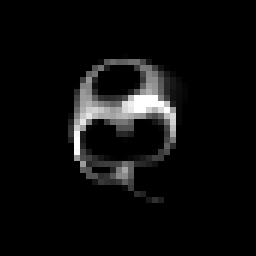

In [39]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")

## Sampling Rules

### Configuration

In [40]:
spatial_dims = (128, 128)
channel_size = 3

R = 12
T = 2

state_scale = 2

### Define sampling distribution

In [41]:
def sample_kernel_params(key: jax.Array, k=3):
	"""Sample kernel parameters according to a specific distribution."""
	key_r, key_b, key_segments = jax.random.split(key, 3)
	r = jax.random.uniform(key_r, minval=0.2, maxval=1.0)

	# Create mask for active segments
	mask = jnp.cumsum(
		jax.nn.one_hot(jax.random.randint(key_segments, (), minval=1, maxval=k + 1), k)
	)

	# Create b array with shape (k,)
	b = jax.random.uniform(key_b, (k,), minval=0.1, maxval=1.0)

	# Fill the inactive segments with nans
	b = jnp.where(mask, jnp.nan, b)

	return KernelParams(r=r, b=b)


def sample_growth_params(key: jax.Array):
	"""Sample growth parameters according to a specific distribution."""
	key_mean, key_std = jax.random.split(key)
	mean = jax.random.uniform(key_mean, minval=0.05, maxval=0.5)
	std = jax.random.uniform(key_std, minval=0.001, maxval=0.18)
	return GrowthParams(mean=mean, std=std)


def sample_rule_params(key: jax.Array, k: int = 3):
	"""Sample rule parameters according to a specific distribution."""
	key_channel_source, key_channel_target, key_weight, key_kernel_params, key_growth_params = (
		jax.random.split(key, 5)
	)

	# Sample channel source and target
	channel_source = jax.random.randint(key_channel_source, (), minval=0, maxval=channel_size)
	channel_target = jax.random.randint(key_channel_target, (), minval=0, maxval=channel_size)

	# Sample weight
	weight = jax.random.uniform(key_weight, minval=0.01, maxval=1.0)

	# Sample kernel and growth parameters
	kernel_params = sample_kernel_params(key_kernel_params, k)
	growth_params = sample_growth_params(key_growth_params)

	return RuleParams(
		channel_source=channel_source,
		channel_target=channel_target,
		weight=weight,
		kernel_params=kernel_params,
		growth_params=growth_params,
	)

In [42]:
seed = 0

key = jax.random.key(seed)
keys = jax.random.split(key, 15)
rule_params = jax.vmap(sample_rule_params)(keys)

### Instantiate Lenia with sampled rules

In [43]:
ca = Lenia(
	spatial_dims=spatial_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	state_scale=state_scale,
	rule_params=rule_params,
)

### Sample rules

In [44]:
seed = 1

key = jax.random.key(seed)
keys = jax.random.split(key, 15)
rule_params = jax.vmap(sample_rule_params)(keys)

Update the rule parameters if you want:

In [45]:
ca.update_rule_params(rule_params)

### Run

In [46]:
state_init = sample_state(pattern)
state_final, states = ca(state_init, num_steps=256)

### Visualize

Uniformly sampled Lenia rule parameters often result in patterns that either vanish or explode. For a more stable approach, see [examples/21_flow_lenia.ipynb](../examples/21_flow_lenia.ipynb).


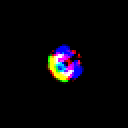

In [47]:
states = jnp.concatenate([state_init[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")